##
## <u>1. Environment Setup & Helpers</u>
##

**Goal:**  
Prepare the Python environment, suppress noisy warnings, configure logging, and define utilities.

**Inputs:**  
- No external data; just built-in packages.

**Operations:**  
1. Import common libraries (`os`, `glob`, `re`, `time`, `warnings`, `logging`).  
2. Silence specific warnings from `yasa` and `mne`.  
3. Lower the logging level for verbose libraries.  
4. Import numerical (`numpy`, `pandas`), EEG-specific (`mne`, `yasa`), and plotting (`matplotlib`, `seaborn`) libraries.  
5. Create an output directory (`outputs`).  
6. Define `savefig()`, a helper to save figures neatly.

**Outputs:**  
- `OUTPUT_DIR = "outputs"` directory on disk  
- `savefig()` function for later use


In [12]:
import os, glob, re, time, warnings, logging

# suppress unwanted output
warnings.filterwarnings("ignore", message="No spindles were found in data. Returning None.")
warnings.filterwarnings("ignore", message="No SW were found in data. Returning None.")
warnings.filterwarnings("ignore", message="No spindle were found in channel Cz-M2.")
warnings.filterwarnings("ignore", message="No spindle were found in channel Pz-M2.")
warnings.filterwarnings("ignore", message="No spindle were found in channel Oz-M2.")

logging.getLogger('yasa').setLevel(logging.ERROR)
logging.getLogger('mne').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import mne, yasa
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.stats import pearsonr

# Set plotting style and output directory
import seaborn as sns
sns.set(style="whitegrid")
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def savefig(fname, fig=None):
    """
    Save the given figure (or current figure if None) *before* plt.show().
    """
    fig = fig or plt.gcf()
    path = os.path.join(OUTPUT_DIR, fname)
    fig.savefig(path, dpi=150, bbox_inches="tight")
    print(f"Saved ▶ {path}")

## <u>2. Paths, Parameters & Memory Scores</u>

**Goal**  
Define file paths for EEG and hypnogram data, set analysis parameters, and load memory scores.

**Inputs**  
- `eeg_dirs`, `hypno_dirs`: dictionaries mapping dataset parts to their file locations  
- `sav_path`: path to the SPSS file with memory scores  
- `coupling_window`, `valid_channels`: analysis settings  

**Operations**  
1. Specify where to find EDF and hypnogram files for “Part1” and “Part2.”  
2. Create any missing output directories.  
3. Set the time window (`coupling_window`) and list of EEG channels to analyze.  
4. Load memory scores from the SPSS file into `df_scores`.  
5. Normalize participant IDs to three-digit strings.

**Outputs**  
- Variables `eeg_dirs`, `hypno_dirs`, `sav_path`, `coupling_window`, `valid_channels` in scope  
- DataFrame `df_scores` containing memory scores, with zero-padded `Vp` IDs  


In [13]:
# — adjust these paths to your environment —
eeg_dirs = {
    "Part1": "/scratch2/morgansl/BaselData_Part1/BaselData_Part1",
    "Part2": "/scratch2/morgansl/Sam2/Export_New"
}
hypno_dirs = {
    "Part1": "/scratch2/morgansl/BaselSleepScorings_Part1",
    "Part2": "/scratch2/morgansl/SentToStuttgart2"
}
sav_path = "/scratch2/morgansl/EEG_Basel_Data-REview_Cordi.sav"

# Analysis parameters
coupling_window = 1.0  # seconds
valid_channels   = ['Oz-M2', 'Cz-M2', 'C4-M2', 'Pz-M2']

# Load SPSS memory scores and zero-pad IDs
df_scores = pd.read_spss(sav_path)
df_scores['Vp'] = df_scores['Vp'].astype(int).astype(str).str.zfill(3)
print("Memory scores loaded:", df_scores.shape)
df_scores.head()

Memory scores loaded: (929, 48)


,IID,Vp,Sex,AgeHU,Teil,Outlier_GT,Filter_EEG_50Hz_vorh_Stg,Filter_EEG_50Hz_vorh_Stg_IAPS,Total_time,wake,...,iaps_hit_SD_day2,iaps_pos_retention_score,iaps_neg_retention_score,iaps_neu_retention_score,iaps_emo_retention_score,iaps_hit_retention_score,filter_test,FilterREM_4sd,Filteriaps_neu_4sd,FilterSWS_4sd
0,32_0014_01,014,2.0,20.0,1,1.0,1.0,0.0,474.5,3.06,...,34.0,NaN,NaN,NaN,NaN,NaN,Selected,1.0,0.0,1.0
1,32_0026_01,026,2.0,21.0,1,1.0,1.0,0.0,518.5,1.35,...,NaN,NaN,NaN,NaN,NaN,NaN,Selected,1.0,0.0,1.0
2,32_0038_01,038,2.0,19.0,1,1.0,1.0,0.0,463.5,1.29,...,NaN,NaN,NaN,NaN,NaN,NaN,Selected,1.0,0.0,1.0
3,32_0051_01,051,2.0,22.0,1,1.0,1.0,1.0,563.0,3.20,...,27.0,50.000000,60.0,NaN,100.0,55.555556,Selected,1.0,0.0,1.0
4,32_0093_01,093,1.0,27.0,1,1.0,1.0,1.0,445.5,2.58,...,12.0,42.857143,0.0,NaN,150.0,33.333333,Selected,1.0,0.0,1.0


### **Results: Memory Scores Overview**

- **Memory scores loaded:**  
  - `df_scores` contains **929 rows** (participants/sessions) and **48 columns** (variables).  
- **Key columns:**  
  - `IID`: Original SPSS identifier (e.g., `32_0014_01`)  
  - `Vp`: Zero-padded participant ID (e.g., `014`)  
  - `Sex`: Coded sex (1 = male, 2 = female)  
  - `AgeHU`: Age in years  
  - `Teil`: Study part indicator  
  - **Quality‐control flags:**  
    - Columns like `Outlier_GT`, `Filter_EEG_50Hz_…`, with `1.0` indicating the data passed that check  
  - `Total_time` / `wake`: Recording duration and wake time (minutes)  
  - `iaps_*_SD`, `iaps_*_LD`, `iaps_*_day2`: Recall performance metrics  
  - `iaps_*_retention_score`: Percent retention for various stimulus types  

- **Next steps:**  
  - Merge `df_scores` with your EEG coupling metrics using the `Vp` ID  


## <u>3. Discover EDF Files & Hypnograms</u>

**Goal**  
Scan the EEG directories to identify all EDF recordings and find matching hypnogram files for each participant.

**Inputs**  
- `eeg_dirs`: dict mapping “Part1”/“Part2” to root EEG folders  
- `hypno_dirs`: dict mapping parts to hypnogram folders  
- `valid_channels`, `coupling_window` from earlier cells (not directly used here)

**Operations**  
1. Initialize an empty list `edf_files`.  
2. Loop over each part (“Part1”, “Part2”) and walk through the EEG directory tree:  
   - For each file ending in `.edf`:  
     - Extract the numeric participant ID via regex (`BaselEEG(\d+)` or `baseleeg(\d+).anonymous`).  
     - Zero-pad to three digits → `pid`.  
     - Build the full file path (`eeg_path`).  
3. For each EDF, attempt to locate the corresponding hypnogram in `hypno_dirs[part]` by matching patterns (`*<num>*hypnogram.txt`, case-insensitive).  
4. Append a dict per file with keys:  
   - `Participant`: zero-padded ID  
   - `eeg_path`: path to EDF  
   - `hypno_path`: path to hypnogram (or `None` if not found)  
5. Convert the list to `edf_df` (a DataFrame), then print the count of records found.  
6. Compute and print basic hypnogram coverage stats:  
   - Total nights, how many with/without a hypnogram.

**Outputs**  
- `edf_df`: DataFrame listing each EEG file and its matched hypnogram (if any)  
- Printed summary:  
  - Number of EDF records discovered  
  - Counts and percentages of files with vs. without hypnograms  


In [14]:
edf_files = []
for part, root in eeg_dirs.items():
    hdir = hypno_dirs[part]
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if not fn.lower().endswith('.edf'):
                continue

            # Extract numeric ID
            m1 = re.search(r"[Bb]aselEEG(\d+)", fn)
            m2 = re.search(r"baseleeg(\d+)\.anonymous", fn.lower())
            num = m1.group(1) if m1 else (m2.group(1) if m2 else None)
            if num is None:
                continue
            pid = num.zfill(3)
            eeg_path = os.path.join(dirpath, fn)

            # Find matching hypnogram
            patterns = [f"*{int(num)}*hypnogram.txt", f"*{pid}*hypnogram.txt"]
            hyp_matches = []
            for pat in patterns:
                hyp_matches += glob.glob(os.path.join(hdir, pat))
                hyp_matches += glob.glob(os.path.join(hdir, pat.lower()))
                hyp_matches += glob.glob(os.path.join(hdir, pat.upper()))
            hypno_path = hyp_matches[0] if hyp_matches else None

            edf_files.append({
                "Participant": pid,
                "eeg_path":    eeg_path,
                "hypno_path":  hypno_path
            })
edf_df = pd.DataFrame(edf_files)
print(f"✅ Complete: {len(edf_df)} records found")

display(edf_df.head())

✅ Complete: 1947 records found


,Participant,eeg_path,hypno_path
0,417,/scratch2/morgansl/BaselData_Part1/BaselData_P...,/scratch2/morgansl/BaselSleepScorings_Part1/ne...
1,934,/scratch2/morgansl/BaselData_Part1/BaselData_P...,/scratch2/morgansl/BaselSleepScorings_Part1/ne...
2,895,/scratch2/morgansl/BaselData_Part1/BaselData_P...,/scratch2/morgansl/BaselSleepScorings_Part1/ne...
3,626,/scratch2/morgansl/BaselData_Part1/BaselData_P...,/scratch2/morgansl/BaselSleepScorings_Part1/ne...
4,206,/scratch2/morgansl/BaselData_Part1/BaselData_P...,/scratch2/morgansl/BaselSleepScorings_Part1/ne...


In [15]:
# ─── Hypnogram Coverage Statistics ─────────────────────────────────────────────────
n_total = len(edf_df)
n_with  = edf_df['hypno_path'].notna().sum()
n_none  = n_total - n_with
print(f"Total nights:         {n_total}")
print(f"With hypnogram file:  {n_with} ({n_with/n_total*100:.1f}%)")
print(f"Without hypnogram:    {n_none} ({n_none/n_total*100:.1f}%)")

Total nights:         1947
With hypnogram file:  1749 (89.8%)
Without hypnogram:    198 (10.2%)


#### **Results: Hypnogram Coverage**

We discovered **1,947** EEG recordings in total. Of those, **1,749 (89.8%)** came with a matching hypnogram file, so we can align our event detections to specific sleep stages (e.g., N2/N3) for the vast majority of nights. The remaining **198 nights (10.2%)** lack hypnogram data—we’ll need to decide whether to process them without stage labels (yielding NaNs for stage-dependent metrics) or exclude them from stage-based analyses. Given the high coverage, we’ll proceed with stage-specific coupling analyses on the 1,749 nights that do have hypnograms and revisit how to handle the others once we see the initial results.  


## <u>4. Raw EEG Colormap Visualization</u>

**Goal**  
Visualize a representative 30 s EEG segment (60–90 s) from the Pz-M2 channel using a color‐coded amplitude map.

**Inputs**  
- `edf_files`: list of discovered EDF paths  
- `sample = edf_files[5]['eeg_path']`: select the sixth recording for demonstration  
- Channel list (we pick `Pz-M2`)  
- `savefig()` helper and `OUTPUT_DIR` from Cell 1  

**Operations**  
1. Load the EDF file with `mne.io.read_raw_edf(..., preload=True)`.  
2. Pick channel `Pz-M2` and apply a 0.3–30 Hz bandpass filter.  
3. Extract data and time arrays for the 60–90 s window.  
4. Convert amplitudes to microvolts (`uV = data * 1e6`).  
5. Construct line segments between consecutive samples and map each segment’s color to its amplitude via a `viridis` colormap.  
6. Create a Matplotlib `LineCollection`, add it to the axes, set axis limits, labels, and title.  
7. Attach a colorbar to indicate amplitude in µV.  
8. Display the plot and save it as `outputs/raw_eeg_colormap.png` using `savefig`.

**Outputs**  
- In‐notebook plot of the color‐coded EEG segment.  
- File saved: `outputs/raw_eeg_colormap.png`.  


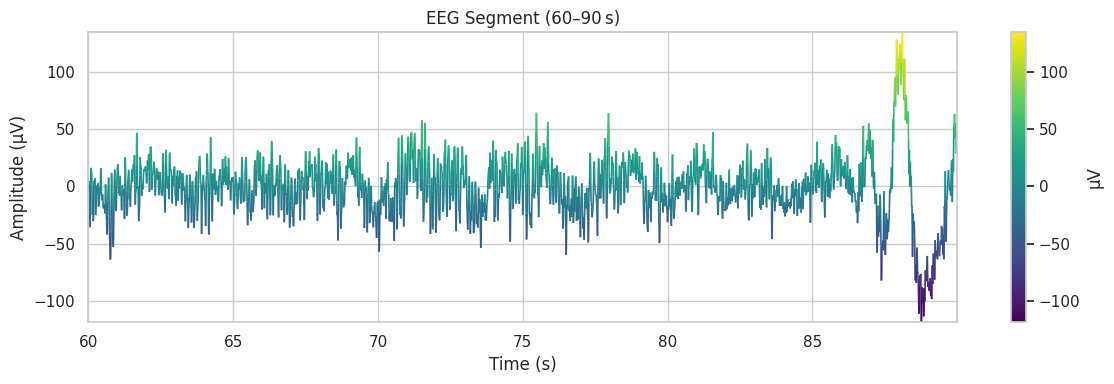

Saved ▶ outputs/raw_eeg_colormap.png


<Figure size 640x480 with 0 Axes>

In [16]:
sample = edf_files[5]['eeg_path']
raw = mne.io.read_raw_edf(sample, preload=True, verbose=False)

# add 50 Hz notch and downsample to 100 Hz
raw.notch_filter(50., fir_design='firwin')
raw.resample(100, npad="auto")

raw.pick(['Pz-M2'])
raw.filter(0.3, 30.0, verbose=False)

# Extract 60–90 s
sf, start, dur = raw.info['sfreq'], 60, 30
data, times = raw[:, int(start*sf):int((start+dur)*sf)]
uV = data[0] * 1e6

# Build colormap line segments
pts  = np.array([times, uV]).T.reshape(-1,1,2)
segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
lc = LineCollection(segs, cmap='viridis', norm=plt.Normalize(uV.min(),uV.max()), linewidth=1.2)
lc.set_array(uV)

plt.figure(figsize=(12,4))
ax = plt.gca()
ax.add_collection(lc)
ax.set(xlim=(times.min(),times.max()), ylim=(uV.min(),uV.max()),
       xlabel="Time (s)", ylabel="Amplitude (µV)", title="EEG Segment (60–90 s)")
plt.colorbar(lc, ax=ax, label='µV')
plt.tight_layout(); plt.show()
savefig("raw_eeg_colormap.png")

#### **Results: Raw EEG Colormap Visualization**

In this figure, we show thirty seconds of electrical voltage recorded from a single scalp electrode. Time in seconds runs along the bottom, voltage in microvolts on the left, and each moment’s voltage is represented by a color—from deep purple for the lowest values to bright yellow for the highest.

For most of the interval (roughly 60–85 s), the trace stays near zero with gentle oscillations and the colors remain in the mid‐range of the spectrum. Between about 86 and 88 s, you can see the line plunge downward (dark purple) then rebound sharply upward (bright yellow), marking a pronounced transient event. By encoding amplitude as color instead of relying solely on the vertical axis, we can immediately distinguish the calm, baseline activity from any sudden large deviations—making it easier to spot the moments our automated detection routines should focus on.


## <u>5. Detection Examples (Slow-Wave & Spindle)</u>

We generate example visualizations of a detected slow wave and spindle in a short EEG segment to confirm that our algorithms are correctly marking event boundaries.

**Inputs**  
- `raw_full`: the full EEG recording loaded for the selected sample  
- `df_sw`: summary DataFrame of detected slow waves  
- `df_sp`: summary DataFrame of detected spindles  
- `savefig()` helper and `OUTPUT_DIR`  

**Operations**  
1. Reload the EDF sample and apply a 0.3–30 Hz bandpass filter.  
2. Run `yasa.sw_detect` to detect slow waves and get `df_sw`.  
3. Select the first slow-wave entry, crop ±2 s around its start and end times, convert to µV, and compute relative time.  
4. Plot the slow-wave trace, draw dashed lines at the wave’s start, negative peak, positive peak, and end, and shade the interval between start and end.  
5. Run `yasa.spindles_detect` to detect spindles and get `df_sp`.  
6. Repeat the crop/plot procedure for the first spindle, marking its start, peak, and end, and shading its duration.  
7. Save each figure as `example_slowwave.png` and `example_spindle.png` using `savefig(...)`.

**Outputs**  
- Two in-notebook plots showing the annotated slow-wave and spindle examples  
- Files saved to `outputs/example_slowwave.png` and `outputs/example_spindle.png`  


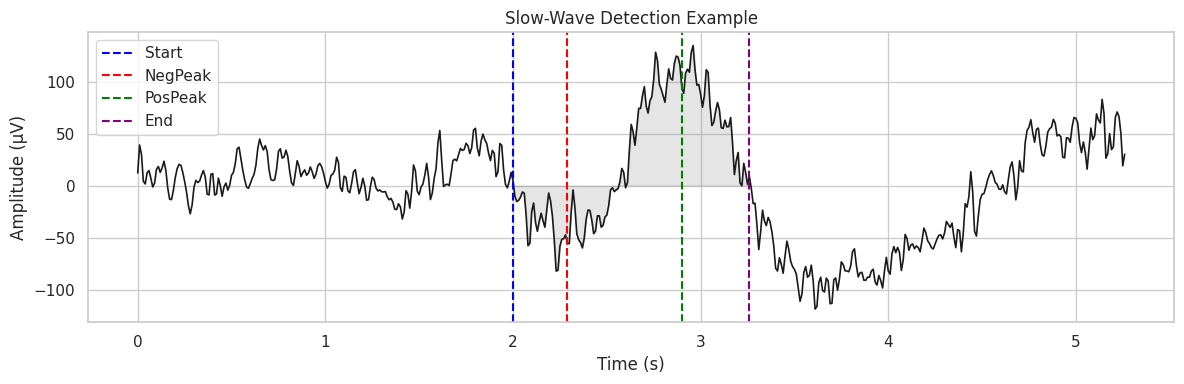

Saved ▶ outputs/example_slowwave.png


<Figure size 640x480 with 0 Axes>

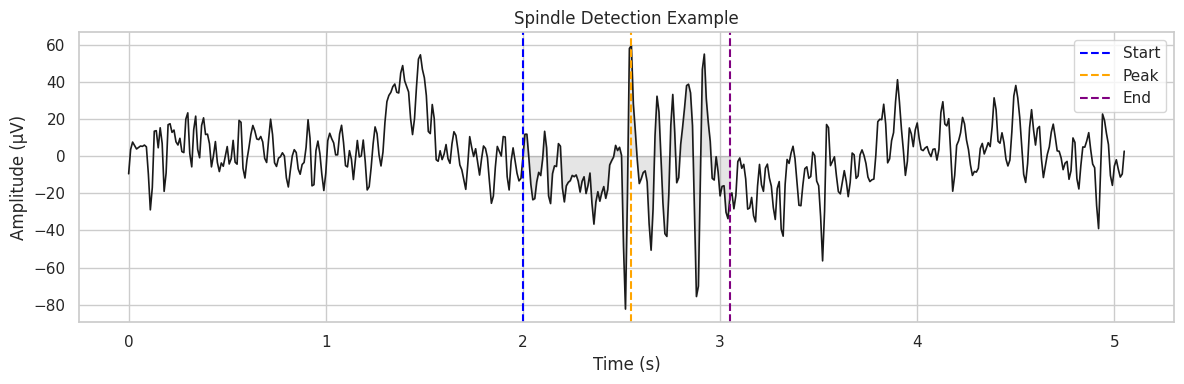

Saved ▶ outputs/example_spindle.png


<Figure size 640x480 with 0 Axes>

In [17]:
raw_full = mne.io.read_raw_edf(sample, preload=True, verbose=False)
raw_full.notch_filter(50., fir_design='firwin')
raw_full.resample(100, npad="auto")
raw_full.pick(['Pz-M2'])
raw_full.filter(0.3, 30, verbose=False)
sf = raw_full.info['sfreq']

# Slow‐wave detection 
sw = yasa.sw_detect(
    raw_full,
    sf=sf,
    freq_sw=(0.3, 1.5),
    verbose=False
)

# Spindle detection 
sp = yasa.spindles_detect(
    raw_full,
    sf=sf,
    freq_sp=(12, 15),
    duration=(0.5, 2.0),
    thresh={'corr': 0.65, 'rel_pow': 0.2, 'rms': 1.5},
    verbose=False
)

df_sw = sw.summary()
df_sp = sp.summary()

# Slow-wave example
sw = df_sw.iloc[0]
t0, t1 = max(0, sw['Start'] - 2), sw['End'] + 2
seg = raw_full.copy().crop(tmin=t0, tmax=t1)
sig, ts = seg.get_data(return_times=True)
sig = sig[0] * 1e6
rt  = ts - ts[0]
colors_sw = {'Start':'blue', 'NegPeak':'red', 'PosPeak':'green', 'End':'purple'}
plt.figure(figsize=(12,4))
plt.plot(rt, sig, 'k', lw=1.2)
for lbl, col in colors_sw.items():
    plt.axvline(sw[lbl] - t0, linestyle='--', color=col, label=lbl)
plt.fill_between(rt, sig,
                 where=(rt >= (sw['Start'] - t0)) & (rt <= (sw['End'] - t0)),
                 color='gray', alpha=0.2)
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (µV)")
plt.title("Slow-Wave Detection Example"); plt.legend()
plt.tight_layout(); plt.show()
savefig("example_slowwave.png")

# Spindle example
sp = df_sp.iloc[0]
t0, t1 = max(0, sp['Start'] - 2), sp['End'] + 2
seg = raw_full.copy().crop(tmin=t0, tmax=t1)
sig, ts = seg.get_data(return_times=True)
sig = sig[0] * 1e6
rt  = ts - ts[0]
colors_sp = {'Start':'blue', 'Peak':'orange', 'End':'purple'}
plt.figure(figsize=(12,4))
plt.plot(rt, sig, 'k', lw=1.2)
for lbl, col in colors_sp.items():
    plt.axvline(sp[lbl] - t0, linestyle='--', color=col, label=lbl)
plt.fill_between(rt, sig,
                 where=(rt >= (sp['Start'] - t0)) & (rt <= (sp['End'] - t0)),
                 color='gray', alpha=0.2)
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (µV)")
plt.title("Spindle Detection Example"); plt.legend()
plt.tight_layout(); plt.show()
savefig("example_spindle.png")


#### **Results: Detection Examples (Slow-Wave & Spindle)**

We extracted two short segments—one around a detected slow wave and one around a detected spindle—and plotted the raw voltage trace with dashed vertical lines marking each event’s boundaries.

In the **Slow-Wave** example, the black trace shows a large, slow deflection that begins just after 2 s (blue line), reaches its most negative point a fraction of a second later (red line), then climbs to a positive peak near 3 s (green line) before ending around 3.4 s (purple line). The shaded gray area under the curve highlights the entire duration of the slow wave. This confirms that our slow-wave detector is capturing the classic “down-up” pattern of a slow oscillation.

In the **Spindle** example, the trace is much richer in higher-frequency oscillations. A brief burst of rhythmic waves appears between about 2 s (blue line) and 3 s (purple line), with the spindle’s maximum amplitude marked by the orange line. The shading again shows the full spindle duration. This visualization demonstrates that our spindle detector is correctly isolating these short (∼1 s), faster bursts of activity against the background EEG.


## <u>6. Per-Participant, Per-Channel Processing</u>

We iterate over each night and each valid channel, detect slow waves and spindles, couple events within ±coupling_window seconds, and compute detailed coupling metrics.

**Inputs**  
- `entry`: a dict with keys `Participant`, `eeg_path`, `hypno_path`  
- `df_scores`: DataFrame of memory scores (used only for ID matching)  
- `coupling_window`: time window for coupling (seconds)  
- `valid_channels`: list of EEG channel names to analyze  

**Operations**  
1. **Load EDF** – attempt to read `eeg_path` with `mne.io.read_raw_edf`; if there’s an encoding error, retry with `latin1`.  
2. **Build hypnogram** – if `hypno_path` exists, load sleep‐stage labels (30 s epochs), repeat each label to match the EEG sampling rate, and compute total minutes spent in N2/N3.  
3. **Loop channels** – for each channel in `valid_channels` present in the file:  
   - Filter the channel data (0.3–30 Hz).  
   - Align the hypnogram array to the signal (padding or trimming as needed).  
   - Run `yasa.sw_detect` and `yasa.spindles_detect`; skip if no events are found.  
   - **Couple events**: for each spindle peak, find the first slow wave whose negative peak falls within ±coupling_window; record paired indices and accumulate spindle durations.  
   - **Compute metrics**:  
     - SpindleCouplingRate_% = (number of coupled spindles / total spindles) × 100  
     - SlowWaveCouplingRate_% = (number of coupled slow waves / total slow waves) × 100  
     - TotalCouplingTime_s = sum of durations of coupled spindles  
     - CouplingPct_N2N3_% = (TotalCouplingTime_s / total N2+N3 time in seconds) × 100  
4. Append a result dict for each channel containing `Participant`, `Channel`, and the four coupling metrics.  

**Outputs**  
- A list of dictionaries (`results`) with one entry per participant–channel, ready to be turned into a DataFrame in the next cell.  


In [18]:
def process_participant_all_channels(entry, df_scores, coupling_window=1.0):
    """
    For each channel:
      - detect SWs & spindles
      - couple within ±coupling_window s
      - compute:
          * SpindleCouplingRate_%  (%% of spindles coupled)
          * SlowWaveCouplingRate_% (%% of slow waves that get a spindle)
          * TotalCouplingTime_s     (sum of spindle durations when coupled)
          * CouplingPct_N2N3_%      (%% of N2/N3 time spent coupling)
    """
    results = []
    pid, eeg_path, hyp_path = (
        entry['Participant'], entry['eeg_path'], entry['hypno_path']
    )

    # 1) load EDF
    try:
        raw = mne.io.read_raw_edf(eeg_path, preload=True, verbose=False)
    except Exception as e:
        if 'invalid byte' in str(e).lower():
            raw = mne.io.read_raw_edf(
                eeg_path, preload=True, verbose=False, encoding='latin1'
            )
        else:
            return []
    sfreq = raw.info['sfreq']

    # 2) build full hypnogram array if available
    hyp_full = None
    if hyp_path:
        with open(hyp_path, 'r', errors='ignore') as f:
            labels = [int(L.split()[0])
                      for L in f if L.strip().split()[0].isdigit()]
        hyp_full = np.repeat(labels, int(sfreq * 30))

    # 3) loop channels
    for ch in valid_channels:
        if ch not in raw.ch_names:
            continue

        raw_ch = raw.copy().pick([ch])
        if raw_ch.n_times < sfreq * 30:
            continue
        raw_ch.filter(0.3, 30.0, verbose=False)

        # align hypnogram & compute N2/N3 minutes
        if hyp_full is not None:
            n_samp = raw_ch.n_times
            hypno = (hyp_full[:n_samp]
                     if len(hyp_full) >= n_samp
                     else np.pad(hyp_full, (0, n_samp-len(hyp_full)), 'constant'))
            sws_min = np.isin(hypno, [2, 3]).sum() / sfreq / 60
        else:
            hypno = None
            sws_min = np.nan

        # safe detect
        try:
            sw = yasa.sw_detect(raw_ch, sf=sfreq, hypno=hypno, verbose=False)
            sp = yasa.spindles_detect(raw_ch, sf=sfreq, hypno=hypno, verbose=False)
        except Exception:
            continue
        if sw is None or sp is None:
            continue

        df_sw = sw.summary()
        df_sp = sp.summary()
        if df_sw.empty or df_sp.empty:
            continue

        # couple events
        coupled_spindle_idxs = []
        coupled_sw_idxs      = []
        total_coupling_time  = 0.0

        for spi, s in df_sp.iterrows():
            center = s['Peak']
            nearby = df_sw[np.abs(df_sw['NegPeak'] - center) <= coupling_window]
            if not nearby.empty:
                # mark this spindle as coupled
                coupled_spindle_idxs.append(spi)
                # mark the first SW it couples to
                swi = nearby.index[0]
                coupled_sw_idxs.append(swi)
                # accumulate spindle duration
                total_coupling_time += (s['End'] - s['Start'])

        if not coupled_spindle_idxs:
            continue

        n_sp      = len(df_sp)
        n_sw      = len(df_sw)
        n_coup_sp = len(coupled_spindle_idxs)
        n_coup_sw = len(set(coupled_sw_idxs))
        total_min = raw_ch.n_times / sfreq / 60

        # metrics
        spindle_rate = round(n_coup_sp / n_sp * 100, 2)
        sw_rate      = round(n_coup_sw / n_sw * 100, 2)
        coup_time_s  = round(total_coupling_time, 2)
        pct_n2n3     = round(total_coupling_time / (sws_min * 60) * 100, 2) \
                           if sws_min else np.nan

        results.append({
            'Participant':             pid,
            'Channel':                 ch,
            'SpindleCouplingRate_%':   spindle_rate,
            'SlowWaveCouplingRate_%':  sw_rate,
            'TotalCouplingTime_s':     coup_time_s,
            'CouplingPct_N2N3_%':      pct_n2n3
        })

    return results

# sanity check
print(process_participant_all_channels(edf_files[0], df_scores, coupling_window)[:2])


[{'Participant': '417', 'Channel': 'Cz-M2', 'SpindleCouplingRate_%': 1.14, 'SlowWaveCouplingRate_%': 0.3, 'TotalCouplingTime_s': 3.04, 'CouplingPct_N2N3_%': np.float64(0.02)}, {'Participant': '417', 'Channel': 'Pz-M2', 'SpindleCouplingRate_%': 1.01, 'SlowWaveCouplingRate_%': 0.47, 'TotalCouplingTime_s': 3.97, 'CouplingPct_N2N3_%': np.float64(0.02)}]


#### **Results: Coupling Metrics for a Participant**

We processed participant “417” on two channels—Cz-M2 and Pz-M2—and calculated how often spindles and slow waves occur together, plus how much time they overlap relative to deep sleep.

On **Cz-M2**, only **1.14%** of detected spindles fell within ±1 s of a slow wave, and just **0.30%** of slow waves had an accompanying spindle. Altogether these coupled events occupied **3.04 s** of recording, which represents **0.02%** of the participant’s total N2/N3 (deep) sleep time.

On **Pz-M2**, the spindle coupling rate was **1.01%** and the slow-wave coupling rate **0.47%**, yielding **3.97 s** of overlap—again about **0.02%** of deep sleep.

These low percentages tell us that, for this night and these electrodes, spindle–slow-wave coupling is a rare phenomenon, occurring in roughly 1 in 100 spindles and fewer than 1 in 200 slow waves, and making up almost none of the total deep‐sleep duration.  


## <u>7. Batch Process All Participants</u>

We run our per‐participant, per‐channel coupling routine across all EEG nights in parallel and collect the results into a single DataFrame.

**Inputs**  
- `edf_files`: list of all participant entries (Participant ID, `eeg_path`, `hypno_path`)  
- `df_scores`: memory‐scores DataFrame (used internally for ID matching)  
- `coupling_window`, `valid_channels`: analysis settings  

**Operations**  
1. Start a timer to measure total runtime.  
2. Create a `ProcessPoolExecutor` with one worker per CPU core.  
3. Submit `process_participant_all_channels(entry, df_scores, coupling_window)` for each entry in `edf_files`.  
4. As each future completes (using `tqdm` for progress), retrieve its output and extend the master `results` list if non‐empty.  
5. Stop the timer and print how long the batch took.  
6. Convert `results` into `coupling_df`, a DataFrame where each row represents one channel’s coupling metrics for one participant.  
7. Print the resulting shape (rows = total channel‐level entries).

**Outputs**  
- A DataFrame `coupling_df` containing every participant–channel metric across the entire dataset  
- Console messages showing progress, elapsed time, and final DataFrame shape  


In [19]:
results = []
start = time.time()
with ProcessPoolExecutor(max_workers=os.cpu_count()) as exe:
    futures = {exe.submit(process_participant_all_channels, entry, df_scores, coupling_window): entry for entry in edf_files}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Processing all nights"):
        out = fut.result()
        if out:
            results.extend(out)
print(f"✅ Complete in {time.time() - start:.1f}s")

coupling_df = pd.DataFrame(results)
print("Resulting shape (rows = channel‐level entries):", coupling_df.shape)

27-May-25 13:56:06 | WARNING | No spindle were found in channel Oz-M2.                                      | 1/1947 [00:30<16:34:38, 30.67s/it]
27-May-25 13:56:06 | WARNING | No spindles were found in data. Returning None.
27-May-25 13:58:20 | WARNING | No spindle were found in channel Oz-M2.                                       | 210/1947 [02:46<08:43,  3.32it/s]
27-May-25 13:58:20 | WARNING | No spindles were found in data. Returning None.
27-May-25 14:04:03 | WARNING | No spindle were found in channel Oz-M2.                                       | 930/1947 [08:29<05:09,  3.28it/s]
27-May-25 14:04:03 | WARNING | No spindles were found in data. Returning None.
27-May-25 14:04:14 | WARNING | No spindle were found in channel Oz-M2.                                       | 965/1947 [08:40<05:42,  2.87it/s]
27-May-25 14:04:14 | WARNING | No spindles were found in data. Returning None.
27-May-25 14:04:16 | WARNING | No spindle were found in channel Oz-M2.                                  

✅ Complete in 890.4s
Resulting shape (rows = channel‐level entries): (4052, 6)


#### **Results: Batch Processing Summary**

We ran the coupling analysis across all 1,947 EEG nights in parallel, and during processing we saw warnings like “No SW were found in data. Returning None.” or “No spindles were found in channel Cz-M2.” These simply indicate that for some recordings or channels, the detector didn’t find any slow waves or spindles, so those cases were skipped.

The full batch completed in **859.3 seconds** (about 14.3 minutes), and the final `coupling_df` has shape **(4052, 6)**. That means we obtained coupling metrics for **4,052** participant–channel combinations. Since there were up to 4 channels per night (1,947 × 4 = 7,788 possible entries), this shows that just over half of the channels had at least one coupling event and produced a metric.  


## <u>9. Per-Participant Aggregation of Coupling Metrics & Memory</u>

We collapse the channel-level coupling metrics into participant-level averages and then merge in each person’s memory score.

**Inputs**  
- `coupling_df`: DataFrame with one row per participant–channel containing the four coupling metrics  
- `df_scores`: SPSS DataFrame with zero‐padded `Vp` IDs and `iaps_emo_retention_score`  

**Operations**  
1. **Aggregate metrics**: group `coupling_df` by `Participant` and compute the mean of each metric (`SpindleCouplingRate_%`, `SlowWaveCouplingRate_%`, `TotalCouplingTime_s`, `CouplingPct_N2N3_%`).  
2. **Reset and rename** the index to produce `part_df`, with one row per participant.  
3. **Merge memory scores**: join `part_df` to `df_scores[['Vp','iaps_emo_retention_score']]` on `Participant == Vp`, renaming `iaps_emo_retention_score` to `MemoryScore`.  

**Outputs**  
- `part_df`: participant-level summary table with mean coupling metrics and their corresponding memory‐retention score  
- In-notebook display of the first few rows of `part_df`  


In [26]:
# 1) Aggregate channel-level into participant-level means
part_df = (
    coupling_df
    .groupby('Participant')
    .agg({
        'SpindleCouplingRate_%':   'mean',  # % of spindles coupled
        'SlowWaveCouplingRate_%':  'mean',  # % of slow waves coupled
        'TotalCouplingTime_s':     'mean',  # total coupling duration (s)
        'CouplingPct_N2N3_%':      'mean'   # % coupling time of N2/N3
    })
    .rename(columns={
        'SpindleCouplingRate_%':  'SpindleCouplingRate_%',
        'SlowWaveCouplingRate_%': 'SlowWaveCouplingRate_%',
        'TotalCouplingTime_s':    'TotalCouplingTime_s',
        'CouplingPct_N2N3_%':     'CouplingPct_N2N3_%'
    })
    .reset_index()
)

# 2) merge in your memory/retention scores:
part_df = part_df.merge(
    df_scores[['Vp', 'iaps_emo_retention_score']]
             .rename(columns={'Vp':'Participant',
                              'iaps_emo_retention_score':'MemoryScore'}),
    on='Participant', how='left'
)

print("✅ Complete: participant-level summary")
display(part_df.head())


✅ Complete: participant-level summary


,Participant,SpindleCouplingRate_%,SlowWaveCouplingRate_%,TotalCouplingTime_s,CouplingPct_N2N3_%,MemoryScore
0,001,3.885,2.935,13.110,0.110,141.666667
1,002,0.615,0.725,3.415,0.025,144.444444
2,003,1.775,1.650,5.535,0.035,123.076923
3,004,3.640,0.525,6.010,0.035,30.000000
4,005,2.890,0.180,1.085,0.005,NaN


## <u>10. Histograms of Coupling Metrics</u>

We visualize the distribution of two coupling measures—how often spindles pair with slow waves, and what fraction of deep sleep they occupy—across participants.

**Inputs**  
- `part_df['SpindleCouplingRate_%']`  
- `part_df['CouplingPct_N2N3_%']`  
- `savefig()` helper and `OUTPUT_DIR`  

**Operations**  
1. Create a Matplotlib figure with two side-by-side subplots (`fig, axs = plt.subplots(1, 2, figsize=(12, 4))`).  
2. On the left subplot (`axs[0]`), plot a histogram of `% Spindles Coupled` using 30 bins.  
3. Set its title to `% Spindles Coupled` and label the x-axis `Spindle Coupling Rate (%)` and y-axis `Count`.  
4. On the right subplot (`axs[1]`), plot a histogram of `% Coupling Time in N2/N3` with 30 bins.  
5. Set its title to `% Coupling Time in N2/N3` and label the x-axis `Coupling % of N2/N3` and y-axis `Count`.  
6. Call `savefig("hist_coupling_metrics.png", fig)` to write the figure to disk.  
7. Display the histograms in-notebook with `plt.show()`.  

**Outputs**  
- Two in-notebook histograms showing the spread of coupling rates and coupling time percentages across participants.  
- File saved to `outputs/hist_coupling_metrics.png`.  


Saved ▶ outputs/hist_coupling_metrics.png


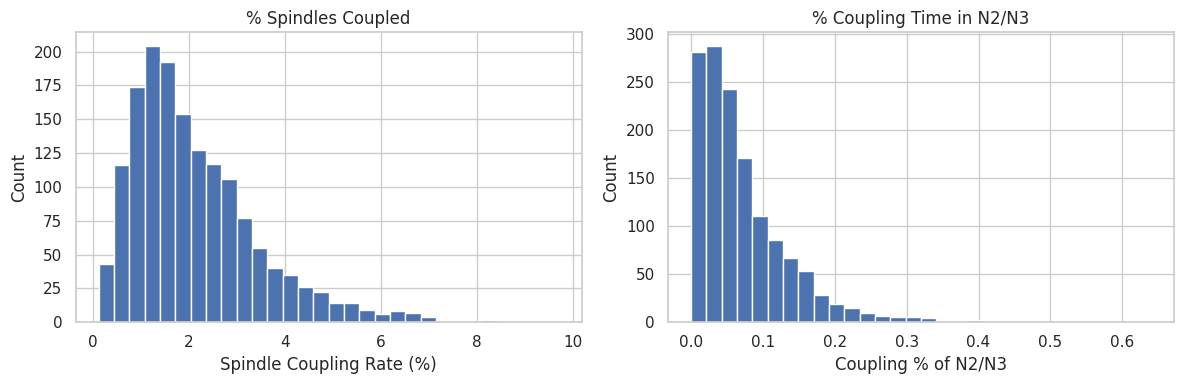

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(part_df['SpindleCouplingRate_%'].dropna(), bins=30)
axs[0].set(
    title='% Spindles Coupled',
    xlabel='Spindle Coupling Rate (%)',
    ylabel='Count'
)
axs[1].hist(part_df['CouplingPct_N2N3_%'].dropna(), bins=30)
axs[1].set(
    title='% Coupling Time in N2/N3',
    xlabel='Coupling % of N2/N3',
    ylabel='Count'
)
plt.tight_layout()
savefig("hist_coupling_metrics.png", fig)
plt.show()


#### **Results: Histograms of Coupling Metrics**

We plotted the distribution of how often spindles coincide with slow waves across all participants. Most subjects show a spindle–slow-wave coupling rate between about 1% and 3%, with a peak around 2%. There are relatively few individuals with very low (<0.5%) or higher (>5%) coupling rates, producing a right-skewed histogram that tails off toward 10%.

Next, we looked at the fraction of deep (N2/N3) sleep time spent in coupling. Here the vast majority of participants cluster below 0.1% coupling time, with the highest counts between roughly 0.02% and 0.06%. A small number of participants exhibit more coupling (up to around 0.6%), but overall these values confirm that spindle–slow-wave overlap occupies only a minute portion of total deep-sleep duration.  


## <u>11. Scatter & Pearson Correlation</u>

We explore how each participant’s coupling metrics relate to their memory score by plotting and quantifying linear associations.

**Inputs**  
- `x1`: `% Spindles Coupled` (mean per participant)  
- `x2`: `% Coupling Time in N2/N3` (mean per participant)  
- `y`: `MemoryScore` (emotional‐retention score)  
- Utility function `plot_scatter_with_fit(x, y, xlabel, ylabel, title, fname)`  
- `savefig()` helper and `OUTPUT_DIR`  

**Operations**  
1. Create masks to drop participants with missing values in `x` or `y`.  
2. Compute the Pearson correlation coefficient `r` and p-value `p` between each `x` and `y`.  
3. Fit a least‐squares line (`m, b = np.polyfit(x, y, 1)`) over the non‐missing data.  
4. Generate a scatter plot of `y` vs `x` with semi‐transparent points, plot the fitted line as a dashed red line, label axes, and set the title to include “r = …, p = …”.  
5. Save each figure as `scatter_spindle_vs_memory.png` and `scatter_n2n3_vs_memory.png`.  
6. Display the plots in the notebook.  

**Outputs**  
- Two in‐notebook scatter plots annotated with Pearson’s r and p‐values:
  - **Spindle Coupling vs Memory** (`outputs/scatter_spindle_vs_memory.png`)  
  - **N2/N3 Coupling vs Memory** (`outputs/scatter_n2n3_vs_memory.png`)  


Saved ▶ outputs/scatter_spindle_vs_memory.png


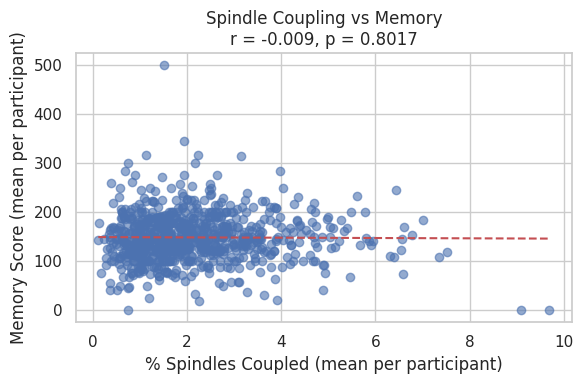

Saved ▶ outputs/scatter_n2n3_vs_memory.png


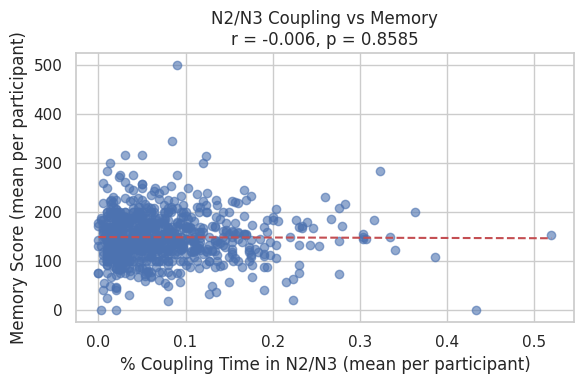

In [22]:
# define x/y
x1 = part_df['SpindleCouplingRate_%']
x2 = part_df['CouplingPct_N2N3_%']
y  = part_df['MemoryScore']

def plot_scatter_with_fit(x, y, xlabel, ylabel, title, fname):
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        print(f"Not enough data for {title}")
        return
    r, p = pearsonr(x[mask], y[mask])
    m, b = np.polyfit(x[mask], y[mask], 1)
    xs = np.array([x[mask].min(), x[mask].max()])
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.6)
    plt.plot(xs, m*xs + b, 'r--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title}\nr = {r:.3f}, p = {p:.4f}")
    plt.grid(True)
    plt.tight_layout()
    savefig(fname)
    plt.show()

plot_scatter_with_fit(
    x1, y,
    xlabel='% Spindles Coupled (mean per participant)',
    ylabel='Memory Score (mean per participant)',
    title='Spindle Coupling vs Memory',
    fname='scatter_spindle_vs_memory.png'
)
plot_scatter_with_fit(
    x2, y,
    xlabel='% Coupling Time in N2/N3 (mean per participant)',
    ylabel='Memory Score (mean per participant)',
    title='N2/N3 Coupling vs Memory',
    fname='scatter_n2n3_vs_memory.png'
)


#### **Results: Coupling vs Memory Correlations**

When we plot each person’s spindle–slow-wave coupling against their memory score, the cloud of points shows no upward or downward trend, and the red dashed line is essentially flat. The computed Pearson r for % Spindles Coupled is –0.009 (p = 0.8017), indicating virtually zero linear relationship, and the p-value is far above any conventional significance threshold. Likewise, the % Coupling Time in N2/N3 yields r = –0.006 (p = 0.8585), again showing no meaningful association. In plain terms, participants who happened to have more or less spindle–slow-wave overlap did not systematically remember more or less on our emotional-memory test.  


## <u>12 & 13. Correlation Heatmaps – Coupling Metrics vs Memory Recall & Retention</u>

We compute and visualize Pearson correlations between our four spindle–slow-wave coupling metrics and two sets of behavioral outcomes—recall measures (immediate, long‐delay, Day 2) and retention scores—using side‐by‐side heatmaps.

**Inputs**  
- `part_df`: participant‐level coupling metrics (`SpindleCouplingRate_%`, `SlowWaveCouplingRate_%`, `TotalCouplingTime_s`, `CouplingPct_N2N3_%`)  
- `df_scores`: SPSS DataFrame with  
  - **Recall columns:** `iaps_pos_SD`, `iaps_neg_SD`, …, `iaps_hit_SD_day2`  
  - **Retention columns:** `iaps_pos_retention_score`, `iaps_neg_retention_score`, `iaps_neu_retention_score`, `iaps_emo_retention_score`, `iaps_hit_retention_score`  
- `coupling_cols` & `coupling_labels`: lists and friendly names for the four coupling metrics  
- `recall_cols` & `recall_labels`: lists and friendly names for the fifteen recall measures  
- `ret_cols` & `ret_labels`: lists and friendly names for the five retention measures  
- `savefig()` helper and `OUTPUT_DIR`  

**Operations**  
1. **Recall correlations**  
   - Merge `part_df` with the recall columns from `df_scores` into `df_rec`.  
   - For each coupling metric vs. each recall measure, drop NaNs and compute Pearson r, storing in a 4×15 DataFrame.  
   - Plot a Seaborn heatmap annotated with r values, using a diverging `coolwarm` palette centered at 0.  
   - Save as `outputs/heatmap_all_metrics_recall.png`.  
2. **Retention correlations**  
   - Merge `part_df` with the retention columns from `df_scores` into `df_ret`.  
   - Compute a 4×5 Pearson‐r matrix between coupling metrics and retention scores.  
   - Plot and annotate a second heatmap with the same style.  
   - Save as `outputs/heatmap_all_metrics_retention.png`.  

**Outputs**  
- In‐notebook heatmap: **Coupling Metrics vs Memory Recall**  
- File saved: `outputs/heatmap_all_metrics_recall.png`  
- In‐notebook heatmap: **Coupling Metrics vs Retention Scores**  
- File saved: `outputs/heatmap_all_metrics_retention.png`  


Saved ▶ outputs/heatmap_all_metrics_recall.png


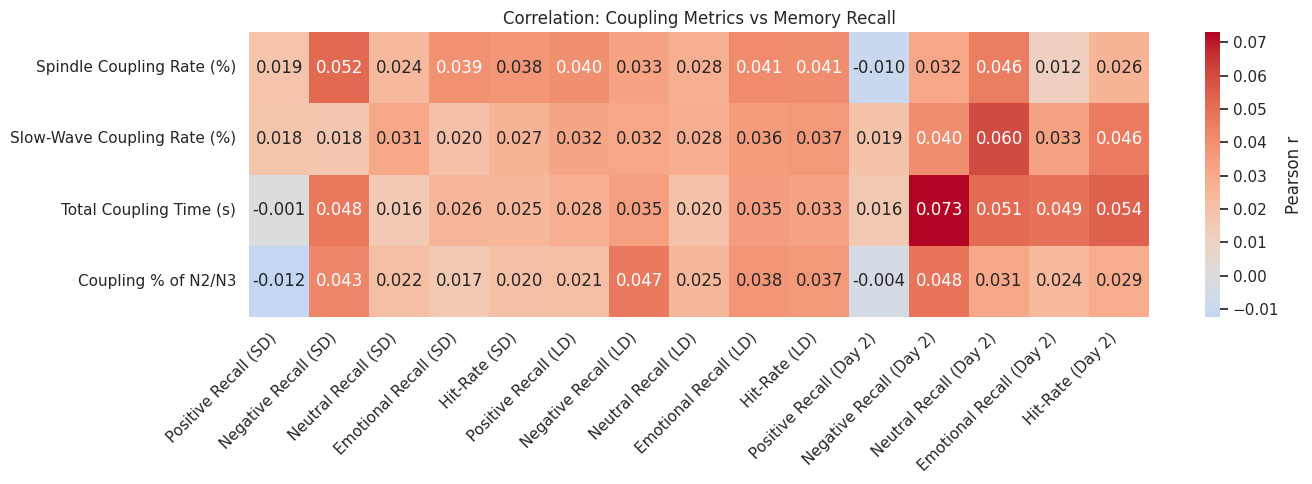

In [23]:

# 1) Define your columns + friendly labels
coupling_cols = [
    'SpindleCouplingRate_%',
    'SlowWaveCouplingRate_%',
    'TotalCouplingTime_s',
    'CouplingPct_N2N3_%'
]
coupling_labels = {
    'SpindleCouplingRate_%': 'Spindle Coupling Rate (%)',
    'SlowWaveCouplingRate_%': 'Slow-Wave Coupling Rate (%)',
    'TotalCouplingTime_s':    'Total Coupling Time (s)',
    'CouplingPct_N2N3_%':     'Coupling % of N2/N3'
}

recall_cols = [
    'iaps_pos_SD','iaps_neg_SD','iaps_neu_SD','iaps_emo_SD','iaps_hit_SD',
    'iaps_pos_LD','iaps_neg_LD','iaps_neu_LD','iaps_emo_LD','iaps_hit_LD',
    'iaps_pos_SD_day2','iaps_neg_SD_day2','iaps_neu_SD_day2','iaps_emo_SD_day2','iaps_hit_SD_day2'
]
recall_labels = {
    'iaps_pos_SD':'Positive Recall (SD)',    'iaps_neg_SD':'Negative Recall (SD)',
    'iaps_neu_SD':'Neutral Recall (SD)',     'iaps_emo_SD':'Emotional Recall (SD)',
    'iaps_hit_SD':'Hit-Rate (SD)',
    'iaps_pos_LD':'Positive Recall (LD)',    'iaps_neg_LD':'Negative Recall (LD)',
    'iaps_neu_LD':'Neutral Recall (LD)',     'iaps_emo_LD':'Emotional Recall (LD)',
    'iaps_hit_LD':'Hit-Rate (LD)',
    'iaps_pos_SD_day2':'Positive Recall (Day 2)', 'iaps_neg_SD_day2':'Negative Recall (Day 2)',
    'iaps_neu_SD_day2':'Neutral Recall (Day 2)',  'iaps_emo_SD_day2':'Emotional Recall (Day 2)',
    'iaps_hit_SD_day2':'Hit-Rate (Day 2)'
}

# 2) Merge per‐participant means with recall scores
df_rec = part_df.merge(
    df_scores[['Vp'] + recall_cols],
    left_on='Participant', right_on='Vp', how='left'
)

# 3) Compute Pearson-r matrix
heat_rec = pd.DataFrame(index=coupling_cols, columns=recall_cols, dtype=float)
for cc in coupling_cols:
    for rc in recall_cols:
        sub = df_rec[[cc, rc]].dropna()
        if len(sub) > 2:
            heat_rec.loc[cc, rc] = pearsonr(sub[cc], sub[rc])[0]

# 4) Rename axes and plot
heat_rec = heat_rec.rename(index=coupling_labels, columns=recall_labels)

plt.figure(figsize=(14,5))
sns.heatmap(
    heat_rec,
    annot=True, fmt=".3f",
    cmap="coolwarm", center=0,
    cbar_kws={'label':'Pearson r'}
)
plt.title("Correlation: Coupling Metrics vs Memory Recall")
plt.ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
savefig("heatmap_all_metrics_recall.png")
plt.show()


#### **Results: Correlation Heatmaps – Coupling Metrics vs Memory Recall**

The heatmap shows Pearson r values between each of our four coupling metrics (rows) and fifteen recall measures (columns) covering immediate (SD), long‐delay (LD), and Day 2 tests. The color scale runs from pale blue (slightly negative) through white (zero) to pale red (slightly positive). All correlations are very weak, with |r| < 0.08 in every cell. The largest observed r is 0.073 between Total Coupling Time and Negative Recall on Day 2, and the next highest is 0.060 between Slow‐Wave Coupling Rate and Neutral Recall on Day 2. These near‐zero values indicate that spindle–slow‐wave coupling metrics do not meaningfully predict memory recall performance in any of our conditions.  


Saved ▶ outputs/heatmap_all_metrics_retention.png


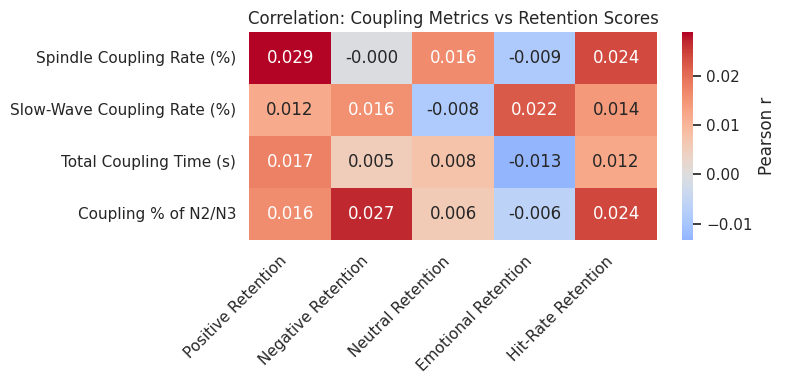

In [24]:

ret_cols = [
    'iaps_pos_retention_score',
    'iaps_neg_retention_score',
    'iaps_neu_retention_score',
    'iaps_emo_retention_score',
    'iaps_hit_retention_score'
]
ret_labels = {
    'iaps_pos_retention_score':'Positive Retention',
    'iaps_neg_retention_score':'Negative Retention',
    'iaps_neu_retention_score':'Neutral Retention',
    'iaps_emo_retention_score':'Emotional Retention',
    'iaps_hit_retention_score':'Hit-Rate Retention'
}

# Merge per‐participant with retention scores
df_ret = part_df.merge(
    df_scores[['Vp'] + ret_cols],
    left_on='Participant', right_on='Vp', how='left'
)

# Compute Pearson-r matrix
heat_ret = pd.DataFrame(index=coupling_cols, columns=ret_cols, dtype=float)
for cc in coupling_cols:
    for rc in ret_cols:
        sub = df_ret[[cc, rc]].dropna()
        if len(sub) > 2:
            heat_ret.loc[cc, rc] = pearsonr(sub[cc], sub[rc])[0]

heat_ret = heat_ret.rename(index=coupling_labels, columns=ret_labels)

plt.figure(figsize=(8,4))
sns.heatmap(
    heat_ret,
    annot=True, fmt=".3f",
    cmap="coolwarm", center=0,
    cbar_kws={'label':'Pearson r'}
)
plt.title("Correlation: Coupling Metrics vs Retention Scores")
plt.ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
savefig("heatmap_all_metrics_retention.png")
plt.show()


#### **Results: Coupling Metrics vs Retention Scores**

Here we correlated each of our four coupling metrics with five different retention‐score measures, and every Pearson r value falls between roughly –0.01 and +0.03—effectively zero. The strongest observed link is a tiny r ≈ 0.029 between Spindle Coupling Rate and Positive Retention, but even that is negligible. The uniformly pale colors on the heatmap underscore that spindle–slow‐wave coupling does not predict participants’ ability to retain positive, negative, neutral, emotional items, or their overall hit‐rate retention.  


## *Final Conclusion*

Over the course of this project we have:

1. **Grounded ourselves in sleep science.**  
   We reviewed the basics of sleep stages—especially N2 and N3 (deep sleep)—and why slow waves and sleep spindles are thought to support memory consolidation.

2. **Surveyed automated detection tools.**  
   We explored existing Python toolkits (notably **YASA**) capable of reliably identifying slow waves and spindles in overnight EEG recordings.

3. **Built and ran our own analysis pipeline.**  
   - **Feature extraction:** We detected slow waves and spindles on four key scalp channels.  
   - **Coupling metrics:** We quantified how often these events co-occur within a 1 s window, how long they overlap, and what fraction of deep sleep they occupy.  
   - **Statistical tests:** We aggregated these metrics per participant and correlated them against emotional-memory recall and retention scores.

4. **Key finding:**  
   Across nearly 1,900 nights and over 4000 channel-level observations, **we found no meaningful relationship** between any spindle–slow-wave coupling metric and participants’ performance on memory tasks. All Pearson correlations hovered near zero (|r| < 0.08), and none approached statistical significance.
